Model Building.

**Program structure**

1. Import packages, pickle files
2. Use custom data generator
3. Model building using ConvNets
4. Visualize model using TensorBoard
5. Visualize predictions


## Import packages & pickle files

In [0]:
#%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib.patches import Rectangle

In [0]:
!pip3 install pydicom
import pydicom
import os
from skimage.transform import resize
import keras
import pickle
import cv2

In [0]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
#Set project path

project_path = '/content/drive/My Drive/Colab Notebooks/CAPSTONE/Data/'
train_img_path = project_path+'stage_2_train_images'
valid_img_path = project_path+'stage_2_train_images'
test_img_path = project_path+'stage_2_test_images'

**Load Pickle files**

In [0]:
#Set pickle files
train_data_pickle = '/train_data_pickle'
valid_data_pickle = '/valid_data_pickle'

#Open file for reading
fileObject = open(project_path+train_data_pickle, 'rb')
fileObject1 = open(project_path+valid_data_pickle, 'rb')

#Load object from the file
train_data = pickle.load(fileObject)
valid_data = pickle.load(fileObject1)

In [0]:
#Find unique patient_ids in train, valid set

train_patient_ids = train_data['patientId'].unique()
print('Unique patient_id in training dataset: {}'. format(train_patient_ids.shape[0]))

valid_patient_ids = valid_data['patientId'].unique()
print('Unique patient_id in validation dataset: {}'. format(valid_patient_ids.shape[0]))

Unique patient_id in training dataset: 21908
Unique patient_id in validation dataset: 5914


## Data Generator

When working with large datasets, existing RAM cannot suffice our processing requirements. Thus data generators are used that helps to load mini-batches of data into the model dynamically.

There are 2 types of Generators:

* ImageDataGenerator - Use this to process only image data
* CustomDataGenerator - Use this to process image, and other types of data 

**Using Custom Data Generator**

In [0]:
class Generator(keras.utils.Sequence):
  def __init__(self,unique_patient_ids, folder, dataframe, batch_size = 32, shuffle = False, image_size = 256, predict = False): #try batch size of 32
    self.unique_patient_ids = unique_patient_ids
    self.folder = folder
    self.dataframe = dataframe
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.image_size = image_size
    self.predict = predict
    self.on_epoch_end()

  def __load__(self, pat_id):
    patIdWithExt = pat_id+'.dcm'
    #load dicom file from pixel array
    img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
    #create empty array
    mask = np.zeros(img.shape)

    if pat_id in self.dataframe['patientId'].values:
      pat_info = self.dataframe[self.dataframe.patientId == pat_id]

      #loop through patient rows in data
      for info in pat_info.iterrows():
        row = info[1]
        if row.Target == 1:
          x = int(row.x)
          y = int(row.y)
          mask[y: int(row.y) + int(row.height), x: int(row.y)+ int(row.width)] = 1

    img = cv2.resize(img, (self.image_size, self.image_size))
    mask = cv2.resize(mask, (self.image_size, self.image_size))
    img = np.expand_dims(img, -1)
    mask = np.expand_dims(mask, -1)
    #img2 = np.concatenate((img,)*3, axis = -1)
    #mask2 = np.concatenate((mask,)*3, axis = -1)
    return img, mask

  def __loadpredict__(self, pat_id):
    patIdWithExt = pat_id
    #load dicom file from pixel array
    img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
    #resize image
    img = resize(img, (self.image_size, self.image_size), mode = 'reflect')
    #add trailing channel dimension
    img = np.expan_dims(img, -1)
    return img    


  def __getitem__(self, index): #called with batch_number as an argument to obtain a given batch of data
    if self.predict:
      #load files
      imgs = [self.__loadpredict__(pat_id_row) for pat_id_row in self.unique_patient_ids]
      #create numpy batch
      imgs = np.array(imgs)
      return imgs, self.unique_patient_ids
    else:
      #select pat_ids by batches
      batch_pat_ids = self.unique_patient_ids[index*self.batch_size : (index+1)* self.batch_size]

      #load pat_ids by loop
      items = [self.__load__(pat_id_row) for pat_id_row in batch_pat_ids]
      imgs, masks = zip(*items)

      #create numpy batch
      imgs = np.array(imgs)
      masks = np.array(masks)
    return imgs, masks

  def __len__(self): #returns no. of steps in the epoch using samples and batch_size
    if self.predict:
      return int(np.ceil(len(self.unique_patient_ids) / self.batch_size))
    else:
      # __len__ provides number of batches per epoch
      return int(np.floor(self.unique_patient_ids.shape[0] / self.batch_size))

  def on_epoch_end(self): #This method is called after every epoch. Here we shuffle order of the dataset
    if self.predict:
      self.indexes = np.arange(len(self.unique_patient_ids))
    else:
      self.indexes = np.arange(self.unique_patient_ids.shape[0])
    if self.shuffle == True:
      np.random.shuffle(self.indexes)


In [0]:
#To be used finally
#train_gen = Generator(train_patient_ids, train_img_path, train_data, batch_size=32, shuffle=False, image_size=256)
#valid_gen = Generator(valid_patient_ids, valid_img_path, valid_data, batch_size=32, shuffle=False, image_size=256)

In [0]:
train_gen = Generator(train_patient_ids[:500], train_img_path, train_data, batch_size=32, shuffle=False, image_size=256)
valid_gen = Generator(valid_patient_ids[:250], valid_img_path, valid_data, batch_size=32, shuffle=False, image_size=256)

## Model building using ConvNet

ConvNets or Convolutional Neural Networks are mostly used to analyze visual imagery. CNN image classification takes an image, process it and classify it.

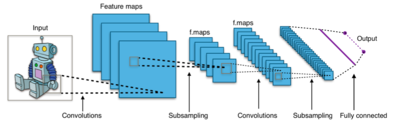

Find BatchNormalization, LeakyRelu

In [0]:
def create_downsample(filters, inputs): #for downsampling, this will be used only once
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs) #normalize inputs, activations
    x = keras.layers.LeakyReLU(0)(x) #using LeakyRelu
    x = keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x) #create Conv2D layer #CHANGED FROM 3 TO 1
    x = keras.layers.MaxPool2D(2)(x) #Maxpooling2D
    return x


def create_resblock(filters, inputs):  #create residual block
  x = keras.layers.BatchNormalization(momentum = 0.9)(inputs)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(filters, 3, padding = 'same', use_bias = False)(x)
  x = keras.layers.BatchNormalization(momentum = 0.9)(x)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(filters, 3, padding = 'same', use_bias = False)(x)
  return keras.layers.add([x, inputs])



def create_cnn_model(input_size, filters, n_blocks = 2, depth = 4):
  inputs = keras.Input(shape=(input_size, input_size, 1)) #Used to instantiate a keras tensor
  x = keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(inputs) #create Conv2D layer using inputs generated above
  #create residual blocks
  for d in range(depth):
    filters = filters * 2
    x = create_downsample(filters, x)
    for b in range(n_blocks):
      x = create_resblock(filters, x)
  
  #output
  x = keras.layers.BatchNormalization(momentum=0.9)(x)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
  outputs = keras.layers.UpSampling2D(2**depth)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [0]:
model = create_cnn_model(input_size = 256, filters = 32, n_blocks = 2, depth = 4)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 256, 256, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

## Visualize CNN model

In [0]:
#Initializing the tensorboard callback for visualization of training

#For COLAB
#Import tensorboard colab modules for creating a tensorboard call back which will pass in model.fit function

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from time import time

#Tensorboard callback is going to be added to model.fit function to draw graphs of loss values after every epoch
tbc = TensorBoardColab()

#For KAGGLE
# Load the extension and start TensorBoard

#%load_ext tensorboard
#%tensorboard --logdir logs

import tensorflow as tf
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

Wait for 8 seconds...


**Compile model**

In [0]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

**Define Checkpoint & Early Stopping**

In [0]:
checkpoint = ModelCheckpoint("model_{loss:.2f}.h5", 
                             monitor = 'val_loss', verbose = 1, 
                             save_best_only = True, save_weights_only = True,
                             mode = 'auto', period = 1)

stop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'auto')

In [0]:
history = model.fit_generator(train_gen,
                              validation_data = valid_gen,
                              callbacks = [checkpoint, reduce_lr, stop],
                              epochs = 4, 
                              workers = 1,
                              use_multiprocessing = True)


Epoch 1/4
14/15 [===========================>..] - ETA: 48s - loss: 0.7146 - accuracy: 0.7029 Epoch 1/4
Epoch 1/4
15/15 [==============================] - 839s 56s/step - loss: 0.6814 - accuracy: 0.7191 - val_loss: 0.5468 - val_accuracy: 0.8674

Epoch 00001: val_loss improved from inf to 0.54679, saving model to model_0.68.h5
Epoch 2/4
15/15 [==============================] - 821s 55s/step - loss: 0.1293 - accuracy: 0.9682 - val_loss: 0.2189 - val_accuracy: 0.9535

Epoch 00002: val_loss improved from 0.54679 to 0.21890, saving model to model_0.13.h5
Epoch 3/4
15/15 [==============================] - 825s 55s/step - loss: 0.1140 - accuracy: 0.9683 - val_loss: 0.1498 - val_accuracy: 0.9747

Epoch 00003: val_loss improved from 0.21890 to 0.14976, saving model to model_0.11.h5
Epoch 4/4
15/15 [==============================] - 832s 55s/step - loss: 0.1094 - accuracy: 0.9683 - val_loss: 0.1043 - val_accuracy: 0.9769

Epoch 00004: val_loss improved from 0.14976 to 0.10434, saving model to mo

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

Predicting for test images.. need to look at this.

## For test dataset

In [0]:
test_filenames = os.listdir(test_img_path)
print('n test samples:', len(test_filenames))


In [0]:
test_gen = Generator(test_filenames[:100], test_img_path, valid_df, batch_size=100, shuffle=False, image_size=256, predict=True)
pred = model.predict(test_gen)

https://www.researchgate.net/publication/335378335_Deep_Learning_for_Medical_Image_Segmentation_Pneumonia_Detection/link/5d60eaa7299bf1f70b08b4a0/download